# **Data Modelling and Evaluation**
---

## Objectives

* Answer Business Requirement 2 & 3:
  * We will create and fit an ML model to predict if a leaf is healthy or infected with powdery mildew. This will be a binary classification task as there are only 2 categories to identify.
  * We want to generate reports of the model that is accessible to all users so that the data can be interpreted and understood.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* inputs/cherry_leaves_dataset/cherry-leaves/test
* Image Shape Embeddings

## Outputs

* Plot distribution of images in train, validation and test sets
* Image augmentation
* Class indices to change prediction inference in labels
* Build ML Model and train it
* Save model
* Plot a learning curve for model performance
* Model evaluation on pickle file
* Prediction on the random image file

## Additional Comments

* No comments
---

### Import Packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Set working directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves-p5/jupyter_notebooks'

In [4]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves-p5')
print('You set a new current directory')

You set a new current directory


In [5]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves-p5'

### Set input directories

In [6]:
my_data_dir = current_dir + '/' + 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directories

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

# Checks to see if a specified version already exists in the outputs folder in the workspace
if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available. Create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available. Create a new version.


### Set Labels

In [8]:
# Set the labels for the images
labels = os.listdir(train_path)
print('The labels for the images are:', labels)

The labels for the images are: ['healthy', 'powdery_mildew']


### Set Image Shape

In [9]:
# Import saved image shape embedding
import joblib

version = 'v1'
img_shape = joblib.load(filename=f"outputs/{version}/img_shape.pkl")
img_shape

(256, 256, 3)

### Number of Images in each set
- **(Train | Validation | Test)**

* train set | healthy: 1472 images
* train set | powdery_mildew: 1472 images
* validation set | healthy: 210 images
* validation set | powdery_mildew: 210 images
* test set | healthy: 422 images
* test set | powdery_mildew: 422 images




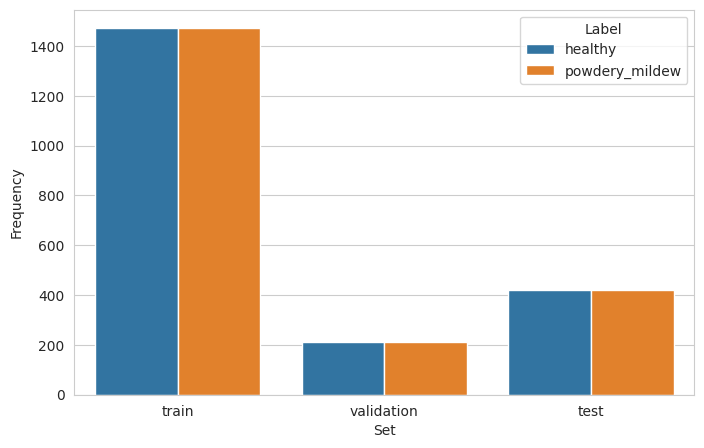

In [14]:
# Initialise list to hold data
data = []

# Define the split of the dataset
folders = ['train', 'validation', 'test']

# Loop through each folder and label and collect the frequency of images
for folder in folders:
    for label in labels:
        folder_path = my_data_dir + '/' + folder + '/' + label
        # Gather the num of images in each folder - label combination
        freq = len(os.listdir(folder_path))
        # Append results as dictionaries to the data array
        data.append({
            'Set': folder,
            'Label': label,
            'Frequency': freq
        })
        # Print a summary of the above logic
        print(f"* {folder} set | {label}: {freq} images")

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the distribution of image frequencies for each label (healthy, powdery_mildew) across each dataset split (train, val, test)
# Saves the plot as a .PNG
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Data Augmentation
---

Import the ImageDataGenerator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-13 16:47:38.970553: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 16:47:39.996899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialise the ImageDataGenerator

In [16]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment each Dataset Split
Train Set:

In [18]:
batch_size = 20 # Set the batch size for training
train_set = augmented_image_data.flow_from_directory(
    train_path, # Path to train set
    target_size=img_shape[:2], # Resize imgs to target size
    color_mode='rgb', # Load in RGB format
    batch_size=batch_size,
    class_mode='binary', # Return the OHE labels (as it is a binary classification model, 'binary' is used)
    shuffle=True
    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Validation Set:

In [19]:
validation_set = ImageDataGenerator(
    # rescale=1./255 normalises the pixel values range from (0–255) to (0.0–1.0), helping the model train more efficiently
    rescale=1./255).flow_from_directory(val_path,
                                        target_size=img_shape[:2],
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=False
                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Test Set:

In [20]:
test_set = ImageDataGenerator(
    rescale=1./255).flow_from_directory(test_path,
                                        target_size=img_shape[:2],
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=False # This ensures you get reliable, reproducible performance metrics.
                                        )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Images for each Set
- Train | Validation | Test

Train Set
Image from Train Set: (20, 256, 256, 3)


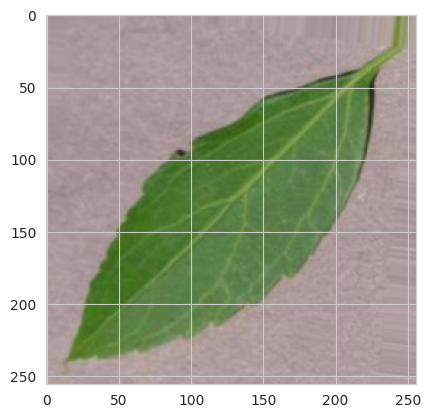

Image from Train Set: (20, 256, 256, 3)


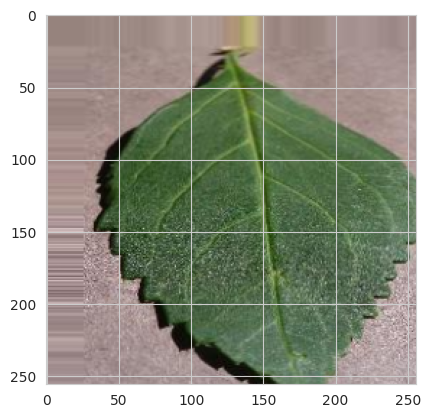

Image from Train Set: (20, 256, 256, 3)


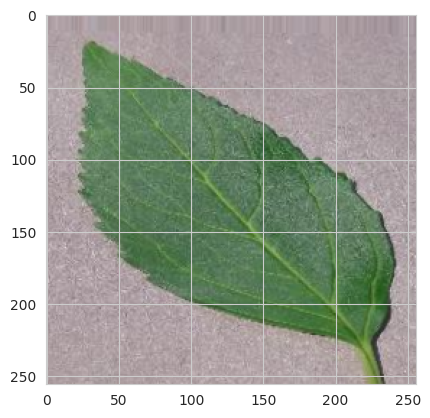

Validation Set
Image from Validation Set: (20, 256, 256, 3)


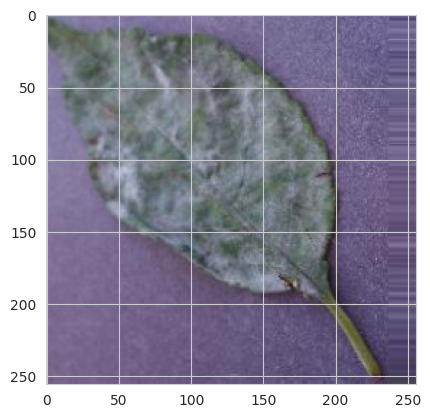

Image from Validation Set: (20, 256, 256, 3)


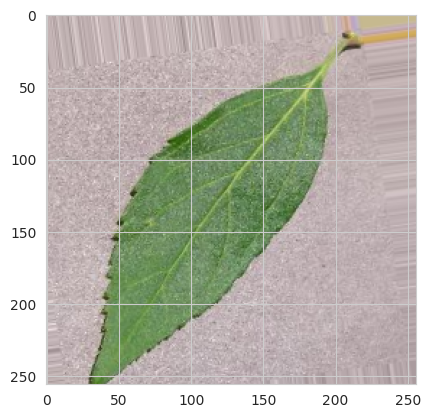

Image from Validation Set: (20, 256, 256, 3)


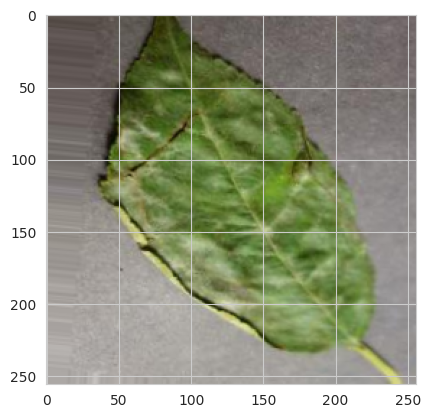

Test Set
Image from Test Set: (20, 256, 256, 3)


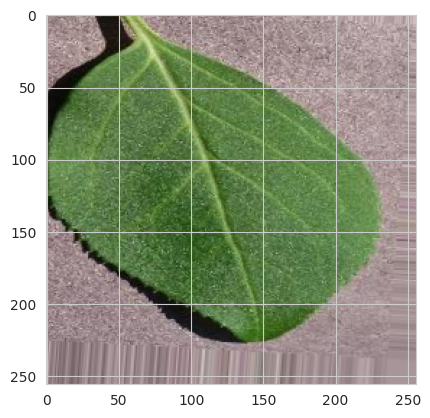

Image from Test Set: (20, 256, 256, 3)


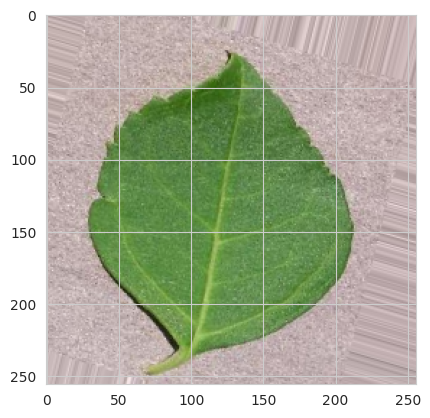

Image from Test Set: (20, 256, 256, 3)


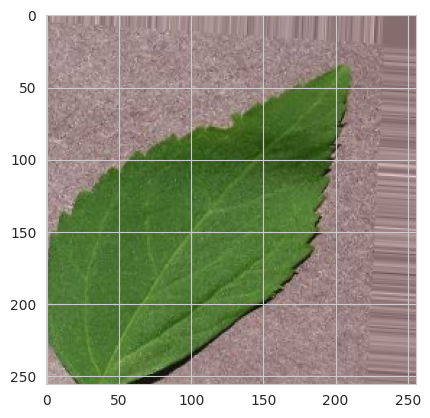

In [ ]:
datasets = {'Train': train_set,
            'Validation': validation_set,
            'Test': test_set}